<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment_2_3/a3_skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Number:

# Student 1:

# Student 2:

# Student 3:

# Downloading Data and Preliminaries

In [1]:
import pickle
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

from zipfile import ZipFile
import requests
import io

In [2]:
def load_zip(url):
    response = requests.get(url)
    response.raise_for_status()
    zipf = ZipFile(io.BytesIO(response.content))
    return {name: zipf.read(name) for name in zipf.namelist()}

def load_pickle(zipfile, fn):
    return pickle.load(io.BytesIO(zipfile[fn]))

In [3]:
data = load_zip('https://surfdrive.surf.nl/files/index.php/s/cwqGaS22KXgnXtg/download')

    
"""
simulation_{train, valid, test} is stored as a list of simulations. 
Each simulation is a numpy array of size (t, 2): For t timesteps an x and y coordinate of our particle.
"""
simulation_train = load_pickle(data, 'data/train/simulation.pickle')  # 3.1 + 3.2
simulation_valid = load_pickle(data, 'data/valid/simulation.pickle')  # 3.1 + 3.2
simulation_test = load_pickle(data, 'data/test/simulation.pickle')  # 3.1 + 3.2

"""
charges_{train, valid, test} is stored as a list of simulation-charges. 
These charges are stored as numpy arrays of size (3,): One value for each charge.
"""
charges_train = load_pickle(data, 'data/train/charges.pickle')  # 3.1
charges_valid = load_pickle(data, 'data/valid/charges.pickle')  # 3.1
charges_test = load_pickle(data, 'data/test/charges.pickle')  # 3.1

"""
simulation_continued_{train, valid, test} is stored as a list of simulations. 
Each simulation is a numpy array of size (t, 2): For t timesteps an x and y coordinate of our particle.
"""
simulation_continued_train = load_pickle(data, 'data/train/simulation_continued.pickle')  # 3.2
simulation_continued_valid = load_pickle(data, 'data/valid/simulation_continued.pickle')  # 3.2
simulation_continued_test = load_pickle(data, 'data/test/simulation_continued.pickle')  # 3.2

"""
Note that the indices are shared throughout the different lists, e.g., for the 4th training simulation:
simulation_train[3] contains its initial simulation
charges_train[3] contains the charges associated with the simulation
simulation_continued_train[3] contains the continuation of the simulation 
                --> simulation_continued_train[3][0] is the state after simulation_train[3][-1]
"""
pass

In [4]:
print('Overview of no. datapoints:\n')

print('Task 3.1:')
print(f'{len(simulation_train)} train, {len(simulation_valid)} validation, {len(simulation_test)} test simulations')
print(f'{len(charges_train)} train, {len(charges_valid)} validation, {len(charges_test)} test charge pairs')
print()

print('Task 3.2:')
print('Since len(simulation_continued_train) < len(simulation_train), we can only use a subset of initial simulations')
print('We cut simulation_train down to the first 150 samples in simulation_train_task32')
simulation_train_task32 = simulation_train[:150]
print(f'{len(simulation_train_task32)} train, {len(simulation_valid)} validation, {len(simulation_test)} test simulations')
print(f'{len(simulation_continued_train)} train, {len(simulation_continued_valid)} validation, {len(simulation_continued_test)} test continuations')

print(f"""
For task 3.1, use:
{chr(10).join(["simulation_{} + charges_{}".format(t, t) for t in ["train", "valid", "test"]])}

For task 3.2, use:
{chr(10).join(["simulation_{} + simulation_continued_{}".format(*((t[0], t[1]) if isinstance(t, tuple) else (t, t))) for t in [("train_task32", "train"), "valid", "test"]])}
""")


Overview of no. datapoints:

Task 3.1:
800 train, 100 validation, 100 test simulations
800 train, 100 validation, 100 test charge pairs

Task 3.2:
Since len(simulation_continued_train) < len(simulation_train), we can only use a subset of initial simulations
We cut simulation_train down to the first 150 samples in simulation_train_task32
150 train, 100 validation, 100 test simulations
150 train, 100 validation, 100 test continuations

For task 3.1, use:
simulation_train + charges_train
simulation_valid + charges_valid
simulation_test + charges_test

For task 3.2, use:
simulation_train_task32 + simulation_continued_train
simulation_valid + simulation_continued_valid
simulation_test + simulation_continued_test



In [5]:
simulation_train[0].shape #so 103 simulation time steps, each has (x,y)coordinates specified

(103, 2)

In [6]:
charges_train[3] #3 values showing three charges for three particles 

array([-0.81015605, -0.67512385, -0.16594701])

In [7]:
print('Print some shapes:\n')
for i in range(3):
    print('simulation_train[{}].shape:'.format(i), simulation_train[i].shape, '-> (t, 2), (x, y) at every t)')
    print('charges_train[{}].shape:'.format(i), charges_train[i].shape, '-> charges for the simulation')
    print('simulation_continued_train[{}].shape:'.format(i), simulation_continued_train[i].shape, '-> (t, 2), (x, y) at every t)')
    print('----\n')

Print some shapes:

simulation_train[0].shape: (103, 2) -> (t, 2), (x, y) at every t)
charges_train[0].shape: (3,) -> charges for the simulation
simulation_continued_train[0].shape: (54, 2) -> (t, 2), (x, y) at every t)
----

simulation_train[1].shape: (97, 2) -> (t, 2), (x, y) at every t)
charges_train[1].shape: (3,) -> charges for the simulation
simulation_continued_train[1].shape: (45, 2) -> (t, 2), (x, y) at every t)
----

simulation_train[2].shape: (99, 2) -> (t, 2), (x, y) at every t)
charges_train[2].shape: (3,) -> charges for the simulation
simulation_continued_train[2].shape: (47, 2) -> (t, 2), (x, y) at every t)
----



In [8]:
def plot_example(x, x_gt=None, x_pred=None, fn=None):
    charge_locations = np.array([[-1.53846154, -1.53846154],
                                 [ 1.53846154, -1.53846154],
                                 [ 0.        ,  1.53846154]])  # charge locations are fixed
    fig = plt.figure()
    axes = plt.gca()
    axes.set_xlim([-5., 5.])
    axes.set_ylim([-5., 5.])
    cmap = matplotlib.cm.get_cmap('tab20')
    plt.plot(x[:, 0], x[:, 1], color=cmap(0))
    plt.plot(x[0, 0], x[0, 1], 'd', color=cmap(1))
    fig.set_size_inches(5, 5)
    for charge in charge_locations:
        plt.plot(charge[0], charge[1], 'd', color='black')
    if x_gt is not None:
        plt.plot(x_gt[:, 0], x_gt[:, 1], color='red', linewidth=.5)
    if x_pred is not None:
        plt.plot(x_pred[:, 0], x_pred[:, 1], color='green', linestyle='--')
    if fn is None:
        plt.show()
    else:
        plt.savefig(fn)

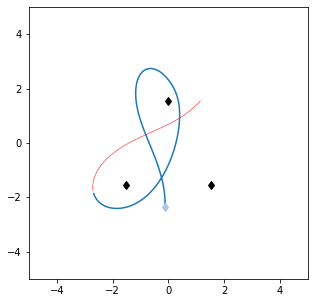

Charges are [-0.9547532  -0.16984018 -0.93072181]


In [9]:
test_idx = np.random.randint(150)
plot_example(simulation_train[test_idx], simulation_continued_train[test_idx])
print(f'Charges are {charges_train[test_idx]}')

In [10]:
simulation_train[test_idx].shape

(94, 2)

In [11]:
simulation_train[test_idx][0][0]

-0.12737266774648764

In [12]:
simulation_train[test_idx][:,0] #takes all rows from only first column index 0 is column 1, x coordinate in this case

array([-0.12737267, -0.12257487, -0.12325074, -0.12968564, -0.14215715,
       -0.1609162 , -0.18615895, -0.21798903, -0.25637356, -0.30110123,
       -0.35175423, -0.4077043 , -0.46813513, -0.53208296, -0.59848193,
       -0.66620181, -0.73407284, -0.80089922, -0.86546815, -0.92656336,
       -0.98299212, -1.03363062, -1.07748497, -1.1137548 , -1.14188036,
       -1.16155791, -1.17272058, -1.17549462, -1.17014656, -1.15703348,
       -1.13656329, -1.10916625, -1.07527645, -1.03532081, -0.98971346,
       -0.93885369, -0.8831262 , -0.82290289, -0.75854581, -0.69041085,
       -0.61885235, -0.54422879, -0.46690987, -0.38728582, -0.30578018,
       -0.22286823, -0.13910499, -0.05517026,  0.02805483,  0.10935017,
        0.18689957,  0.25783146,  0.31772405,  0.36168888,  0.38833813,
        0.40033812,  0.4008972 ,  0.39230854,  0.37606101,  0.35312399,
        0.32413891,  0.28953206,  0.24958051,  0.20445075,  0.15422099,
        0.09889295,  0.03839712, -0.02740581, -0.09872398, -0.17

In [13]:
simulation_train[test_idx][:,1]  #takes all rows from only second column index 1 is second column, y coordinate value in this case

array([-2.35773793, -2.24492854, -2.12346142, -1.9937707 , -1.85638894,
       -1.7119596 , -1.56124207, -1.40510419, -1.24449664, -1.0804072 ,
       -0.91379871, -0.7455423 , -0.57636201, -0.40680478, -0.23724107,
       -0.06789279,  0.10111953,  0.26971827,  0.43780494,  0.6051961 ,
        0.7715655 ,  0.93640233,  1.09899777,  1.25846824,  1.41381304,
        1.56399087,  1.70799353,  1.84489983,  1.97390386,  2.09432098,
        2.20557936,  2.30720406,  2.398799  ,  2.48002958,  2.55060718,
        2.61027603,  2.65880207,  2.69596359,  2.72154315,  2.73532039,
        2.73706528,  2.72653148,  2.70344929,  2.66751792,  2.61839641,
        2.55569279,  2.47895108,  2.38763639,  2.28112122,  2.15868649,
        2.01958855,  1.86337987,  1.69103243,  1.50710089,  1.31909202,
        1.13246833,  0.94932541,  0.77008332,  0.59458525,  0.42251033,
        0.25351697,  0.08729438, -0.07641724, -0.23781699, -0.39703653,
       -0.55413359, -0.70908499, -0.86177878, -1.01200509, -1.15

In [14]:
len(charges_train)
charges_train[1].shape

(3,)

# Task 3.1

## Data Handling and Preprocessing

In [15]:
import torch
from torch.utils.data import DataLoader
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader,TensorDataset, random_split
import numpy as np
from PIL import Image
from torch.nn.utils.rnn import pad_sequence

device=torch.device("cuda" if torch.cuda.is_available()else "cpu")

class MyDataset(Dataset):
  def __init__(self,simulations,charges):

    #maximum length of each simulation performed is 110 seconds
    max_length=110 

    #pad the arrays with zeros so that all sequences have same length
    padded_sim=[]
    for i in range(len(simulations)):
      if len(simulations[i]) != max_length:
          x = np.pad(simulations[i],[(0,max_length-len(simulations[i])),(0,0)], 'constant',constant_values = 0) #padding zeros at the end of dimension 1 ie rows 
      else:
          x = simulations[i]
      padded_sim.append(x)

    data=np.array(padded_sim) #convert list into numpy array data = simulations of all length 110
    #shape of data
    (n_samples,length,dim)=data.shape
    #convert simulations to tensor structure
    self.data=torch.FloatTensor(data).view(n_samples,1,-1) #reshape so that 
    print("Dimensions of data",self.data.shape)
    #convert charges to numpy array first
    charges=np.array(charges)
    self.target=torch.FloatTensor(charges)
    print("Dimensions of label",self.target.shape)


    # #extract the inputs and targets from the new padded simulations all of shape -> (110,2):(time,2)
    # for data in range(len(padded_sim)):
    #   for target in range(len(padded_sim[data])):
    #     self.data = torch.FloatTensor(padded_sim[target])
    #     self.target = torch.FloatTensor(charges[target])


  def __getitem__(self, index):
    X=self.data[index]
    Y=self.target[index]
    return X,Y

  def __len__(self):
    return len(self.data)

    


In [61]:
train_dataset=MyDataset(simulation_train,charges_train)
val_dataset = MyDataset(simulation_valid,charges_valid)
test_dataset=MyDataset(simulation_test,charges_test)
test_loader=torch.utils.data.DataLoader(test_dataset, batch_size=10)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16)


Dimensions of data torch.Size([800, 1, 220])
Dimensions of label torch.Size([800, 3])
Dimensions of data torch.Size([100, 1, 220])
Dimensions of label torch.Size([100, 3])
Dimensions of data torch.Size([100, 1, 220])
Dimensions of label torch.Size([100, 3])


In [40]:
#check how 3rd sample of train dataset looks like
X,Y=test_dataset[2]
print(X)
print(Y)

tensor([[ 2.3561, -0.1385,  2.2400, -0.1432,  2.1133, -0.1518,  1.9764, -0.1643,
          1.8296, -0.1809,  1.6734, -0.2017,  1.5086, -0.2269,  1.3358, -0.2562,
          1.1560, -0.2896,  0.9701, -0.3266,  0.7792, -0.3667,  0.5840, -0.4095,
          0.3855, -0.4544,  0.1842, -0.5009, -0.0191, -0.5488, -0.2242, -0.5981,
         -0.4307, -0.6488, -0.6382, -0.7016, -0.8466, -0.7571, -1.0554, -0.8164,
         -1.2639, -0.8811, -1.4706, -0.9532, -1.6726, -1.0344, -1.8650, -1.1252,
         -2.0435, -1.2232, -2.2055, -1.3249, -2.3508, -1.4271, -2.4798, -1.5280,
         -2.5931, -1.6260, -2.6913, -1.7203, -2.7752, -1.8102, -2.8451, -1.8954,
         -2.9016, -1.9753, -2.9450, -2.0497, -2.9756, -2.1184, -2.9937, -2.1811,
         -2.9996, -2.2375, -2.9933, -2.2875, -2.9752, -2.3309, -2.9452, -2.3674,
         -2.9037, -2.3967, -2.8505, -2.4187, -2.7859, -2.4330, -2.7098, -2.4393,
         -2.6224, -2.4373, -2.5236, -2.4265, -2.4135, -2.4065, -2.2921, -2.3767,
         -2.1595, -2.3363, -

In [18]:
input_dim = next(iter(train_loader))[0].shape[2]
input_dim

220

## Model Implementation

In [19]:
#3.1 task adapted from A2 implementation
from torch import nn
class LSTM_a2(nn.Module):
  def __init__(self,input_dim,hidden_dim,output_dim,device):
    super(LSTM_a2,self).__init__()

    self.input_dim=input_dim
    self.hidden_dim=hidden_dim
    self.device=device

    self.rnn=nn.LSTMCell(input_dim,hidden_dim)
    self.fc1=nn.Linear(hidden_dim,hidden_dim)
    self.fc2=nn.Linear(hidden_dim,output_dim)

    self.criterion=nn.MSELoss()
    #self.optimizer=torch.optim.Adam(self.parameters())
  
  def forward(self,batch_input):

    #shape of input , batch_input: [batch_size, 1,seq_length]
    #generate random initial hidden and cell states
    hidden_0=torch.randn(batch_input.shape[0],self.hidden_dim).to(self.device)
    c_0=torch.randn(batch_input.shape[0],self.hidden_dim).to(self.device)
    for i in range(0,220,2):
             hidden_1,c_1 = self.rnn(batch_input[:,0,i:i+2],(hidden_0,c_0))
            

    
    h1=nn.ReLU()(self.fc1(hidden_1))
    out1=self.fc2(h1)
    
    return out1

  




In [20]:
model=LSTM_a2(2,256,3,device='cpu')

In [21]:
#todo
def save_model_checkpoint(path, model, optimizer, val_loss, val_acc, train_acc, train_loss ):
    if path == None:
        return print("Kindly define a path")
    path = path
    
    save_dict = {"model_dict" : model.state_dict(), 
                 "optimizer_dict": optimizer.state_dict(),
                 "val_loss_dict": val_loss,
                 "val_acc_dict": val_acc,
                 "train_acc_dict": train_acc,
                 "train_loss_dict": train_loss}
    torch.save(save_dict, path)
    return print("Model Saved to ==> {}".format(path))

In [25]:
# training and validation after every epoch
def train(model, train_loader, val_loader, criterion,num_epochs, save_name):
    best_val_loss = float("Inf") 
    train_losses = []
    val_losses = []
    train_acc = []
    val_acc = []
    cur_step = 0
    train_pred = []
    val_pred = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        running_train_acc = 0.0
  
        model.train()
        print("Starting epoch " + str(epoch+1))
        for train_data, targets in train_loader:
            
           
            # Forward
            input_tensor = train_data.to(device)
            outputs = model.forward(input_tensor)
            loss = criterion(outputs,targets.to(device))
            # loss = loss/60
                
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()   
            running_loss += loss
          

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print("Train Pass Completed")

        ########################################|Validation Set|#############################################
        val_running_loss = 0.0
        with torch.no_grad():
            model.eval()
            for val_data, val_targets in val_loader:
                input_tensor = val_data.to(device)
                outputs = model.forward(input_tensor)
                loss = criterion(outputs,val_targets.to(device))
                # loss = loss/60
                val_running_loss += loss

        avg_val_loss = val_running_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        
        print('Epoch [{}/{}],Train Loss: {:.4f}, Valid Loss: {:.8f}' 
            .format(epoch+1, num_epochs, avg_train_loss, avg_val_loss))
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss 
            save_model_checkpoint(save_name, model, optimizer, best_val_loss, 0, 0, avg_train_loss )
    
    print("Finished Training") 
    return train_losses, val_losses
     

In [26]:
#optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr= 1e-4, weight_decay = 0.01)
num_epochs = 300
save_name = f'LSTM_1.pt'
criterion = nn.MSELoss()
# batch_size=32
obtained_train_loss, obtained_val_loss = train(model, 
                                                      train_loader, val_loader, criterion, num_epochs, save_name)

Starting epoch 1
Train Pass Completed
Epoch [1/300],Train Loss: 0.2168, Valid Loss: 0.21318524
Model Saved to ==> LSTM_1.pt
Starting epoch 2
Train Pass Completed
Epoch [2/300],Train Loss: 0.1728, Valid Loss: 0.16879085
Model Saved to ==> LSTM_1.pt
Starting epoch 3
Train Pass Completed
Epoch [3/300],Train Loss: 0.1393, Valid Loss: 0.14615776
Model Saved to ==> LSTM_1.pt
Starting epoch 4
Train Pass Completed
Epoch [4/300],Train Loss: 0.1187, Valid Loss: 0.12341139
Model Saved to ==> LSTM_1.pt
Starting epoch 5
Train Pass Completed
Epoch [5/300],Train Loss: 0.1040, Valid Loss: 0.11137002
Model Saved to ==> LSTM_1.pt
Starting epoch 6
Train Pass Completed
Epoch [6/300],Train Loss: 0.0967, Valid Loss: 0.10459571
Model Saved to ==> LSTM_1.pt
Starting epoch 7
Train Pass Completed
Epoch [7/300],Train Loss: 0.0927, Valid Loss: 0.10135664
Model Saved to ==> LSTM_1.pt
Starting epoch 8
Train Pass Completed
Epoch [8/300],Train Loss: 0.0891, Valid Loss: 0.10063646
Model Saved to ==> LSTM_1.pt
Starting

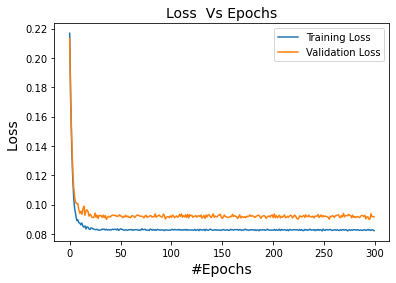

In [27]:
converted_train_loss = [tensor.detach().item() for tensor in obtained_train_loss]
converted_val_loss = [tensor.detach().item() for tensor in obtained_val_loss]

plt.plot(range(0,num_epochs),converted_train_loss, label = "Training Loss")
plt.plot(range(0,num_epochs),converted_val_loss, label = "Validation Loss")
plt.title('Loss  Vs Epochs', fontsize=14)
plt.xlabel('#Epochs', fontsize=14)
plt.ylabel('Loss ', fontsize=14)

plt.legend()
plt.show()


In [24]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 418 kB 5.1 MB/s 


In [70]:

#evaluate on the test set and calculate average test loss 
from sklearn.metrics import mean_squared_error
from torchmetrics import R2Score 
r2score = R2Score().to(device)
def evaluate(model, test_loader,device='cpu'):
    test_running_loss = 0.0
    count=0.0
    r2_score=0.0
    preds = []
    actual = []
    test_input = []
    with torch.no_grad():
        model.eval()
        for test_data, test_label in test_loader:
            input_tensor = test_data.to(device)
            test_input.append(input_tensor)
            outputs = model.forward(input_tensor)
            preds.append(outputs)
            actual.append(test_label)
            loss = torch.sqrt(criterion(outputs,test_label.to(device)))
            test_running_loss += loss
            #score = r2score(outputs, test_label)
            #r2_score += score
            count+=1
            
            print(f"RMSE Loss after {count} iteration :", test_running_loss/count)



        
        avg_test_loss = test_running_loss / len(test_loader)
        avg_r2_score = r2_score / len(test_loader)
        print("Average RMSE Test Loss: {:4f}".format(avg_test_loss))
        #print("Average R2 score: {:4f}".format(avg_r2_score))
        return preds, actual, test_input



In [71]:
preds,actual, input= evaluate(model,test_loader)

RMSE Loss after 1.0 iteration : tensor(0.2959)
RMSE Loss after 2.0 iteration : tensor(0.3016)
RMSE Loss after 3.0 iteration : tensor(0.2813)
RMSE Loss after 4.0 iteration : tensor(0.2784)
RMSE Loss after 5.0 iteration : tensor(0.2776)
RMSE Loss after 6.0 iteration : tensor(0.2836)
RMSE Loss after 7.0 iteration : tensor(0.2894)
RMSE Loss after 8.0 iteration : tensor(0.2862)
RMSE Loss after 9.0 iteration : tensor(0.2846)
RMSE Loss after 10.0 iteration : tensor(0.2880)
Average RMSE Test Loss: 0.288022


In [ ]:
#LSTM  done for A2 implementation
from torch import nn
class LSTM_a2_test(nn.Module):
  def __init__(self,input_dim,hidden_dim,output_dim,device):
    super(LSTM_a2_test,self).__iniit__()

    self.input_dim=input_dim
    self.hidden_dim=hidden_dim
    self.device=device

    self.rnn=nn.LSTMCell(input_dim,hidden_dim)
    self.fc1=nn.Linear(hidden_dim,hidden_dim)
    self.fc2=nn.Linear(hidden_dim,output_dim)

    self.criterion=nn.MSELoss()
    self.optimizer=torch.optim.Adam(self.parameters())
  
  def forward(self,batch_input):

    #shape of input , batch_input:[batch_size,seq_length,input_shape]
    #generate initial hidden and cell states
    hidden_0=torch.randn(batch_input.shape[0],self.hidden_dim).to(self.device)
    c_0=torch.randn(batch_input.shape[0],self.hidden_dim).to(self.device)

    #feeding input sequence to lstm(same input fed to all lstms)
    hidden_1,c_1 = self.rnn(batch_input,(hidden_0,c_0))
    hidden_2,c_2 = self.rnn(batch_input,(hidden_1,c_1))
    hidden_3,c_3 = self.rnn(batch_input,(hidden_2,c_2))

    h1=nn.ReLU()(self.fc1(hidden_1))
    out1=self.fc2(h1)
    h2=nn.ReLU()(self.fc1(hidden_2))
    out2=self.fc2(h2)
    h3=nn.ReLU()(self.fc1(hidden_3))
    out3=self.fc2(h3)

    y_preds = torch.stack((out1,out2,out3),axis=1)
    return y_preds

  




## Model Training

In [ ]:
#todo

## Evaluation

In [ ]:
#todo

# Task 3.2

## Data Handling and Preprocessing

In [ ]:
#todo


## Model Implementation

In [ ]:
#todo

## Model Training

In [ ]:
#todo

## Evaluation

In [ ]:
#todo